# Causal Analysis of Synthetic Dataset

In [235]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'ContinentOfBirth'
#TREATMENT_COL = 'CitizenshipContinent'

treatment_subdimensions = ['CitizenshipCountry'] if TREATMENT_COL == 'CitizenshipContinent' else ['CountryOfBirth']

OUTCOME_NAME = 'Last Name Correct'

TREATMENT = 'T'
OUTCOME = 'O'

In [236]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'Last Name Correct'],
      dtype='object')

In [237]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == 'Asia'
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL, 'Last Name'] + treatment_subdimensions, axis=1).columns.values
CONT_COVARIATES = ['NumChildren']
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [4]:
dataset.columns

Index(['Source', 'Last Name', 'CountryOfBirth', 'ContinentOfBirth',
       'CitizenshipCountry', 'CitizenshipContinent', 'NumChildren',
       'MaritalStatus', 'O', 'T'],
      dtype='object')

In [248]:
def propensity_score(data, n_models = 50):
    m = Matcher(data[data[TREATMENT] == 1], data[data[TREATMENT] == 0], yvar=TREATMENT, exclude=['Last Name', OUTCOME, TREATMENT_COL] + treatment_subdimensions)
    m.fit_scores(balance=True, nmodels=n_models)
    m.predict_scores()
    return m.data.copy()

def propensity_stratification(scored_data, continuous_covariates, categorical_covariates, num_strata=50, min_count_per_stratum=10, alpha=.05):
    scored_data['stratum'] = pd.qcut(scored_data['scores'], num_strata, labels=False)
    
    for col in continuous_covariates + categorical_covariates:
        treated_contingencies = scored_data[scored_data[TREATMENT] == 1].groupby('stratum')[col].value_counts()
        control_contingencies = scored_data[scored_data[TREATMENT] == 0].groupby('stratum')[col].value_counts()
        contingencies = pd.concat([treated_contingencies, control_contingencies], axis=1).fillna(0)
        contingencies.columns = ['treatment_contingency', 'control_contingency']
        
        for stratum in contingencies.index.get_level_values(0).unique():
            if col in categorical_covariates:
                contingency = contingencies.loc[stratum].T.values
                p_val = scipy.stats.chi2_contingency(contingency)[1]
            else:
                ks_test = scipy.stats.ks_2samp(scored_data[scored_data[TREATMENT] == 1][col], scored_data[scored_data[TREATMENT] == 0][col])
            critical_value = np.sqrt(-np.log(alpha) / 2) * np.sqrt(2 * n_iter/(n_iter * n_iter))
            if ks_test[0] > critical_value and ks_test[1] < alpha:
                    print('Covariate {0} not balanced enough in stratum {1}. p-value {2:.6f}'.format(col, stratum, p_val))
    
    scored_data['Tbar'] = (1 - scored_data[TREATMENT])
    scored_data['T_y'] = scored_data[TREATMENT] * scored_data[OUTCOME]
    scored_data['Tbar_y'] = scored_data['Tbar'] * scored_data[OUTCOME]

    stratified = scored_data.groupby('stratum').filter(lambda stratum: min(stratum.loc[stratum[TREATMENT] == 1].shape[0],
                                                                           stratum.loc[stratum[TREATMENT] == 0].shape[0]) > min_count_per_stratum)

    lost = list(filter(lambda x: x not in stratified['stratum'].unique(), range(num_strata)))
    if len(lost) > 0:
        print('Lost strata: {}. They were too small.'.format(lost))

    agg_outcomes = stratified.groupby('stratum').agg({TREATMENT: ['sum'], 'Tbar': ['sum'], 'T_y': ['sum'], 'Tbar_y': ['sum']})
    agg_outcomes.columns = ["_".join(x) for x in agg_outcomes.columns.ravel()]
    treatment_sum_name = TREATMENT + "_sum"

    agg_outcomes['T_y_mean'] = agg_outcomes['T_y_sum'] / agg_outcomes[treatment_sum_name]
    agg_outcomes['Tbar_y_mean'] = agg_outcomes['Tbar_y_sum'] / agg_outcomes['Tbar_sum']
    agg_outcomes['effect'] = agg_outcomes['T_y_mean'] - agg_outcomes['Tbar_y_mean']
    treatment_population = agg_outcomes[treatment_sum_name].sum()

    treatment_effect_among_treated = (agg_outcomes['effect'] * agg_outcomes[treatment_sum_name]).sum()
    return treatment_effect_among_treated, treatment_population

# Explicitly control for highly correlated covariate, then do propensity stratification.
# Explicit control is needed, because otherwise covariates won't be balanced within the strata.
def match_then_stratify(dataset, exact_match_vars, n_models=50, num_strata=5, min_count_per_stratum=10, alpha=.05):
    cum_tt = 0
    cum_count = 0
    for key, data in dataset.groupby(exact_match_vars):
        scored = propensity_score(data.drop(exact_match_vars, axis=1), n_models=n_models)
        tt, count = propensity_stratification(scored, list(c for c in CONT_COVARIATES if c not in exact_match_vars), 
                                                      list(c for c in CAT_COVARIATES if c not in exact_match_vars), num_strata, 
                                              min_count_per_stratum, alpha)
        cum_tt += tt
        cum_count += count

    att = cum_tt / cum_count
    return att  # Average treatment effect among treated. ("How would the outcome for the treated subpopulation change if they hadn't been treated.")

match_vars = ['CitizenshipContinent'] if TREATMENT_COL == 'ContinentOfBirth' else ['ContinentOfBirth']
match_then_stratify(dataset, match_vars)

Formula:
T ~ Source+CitizenshipCountry+NumChildren+MaritalStatus
n majority: 3016
n minority: 305
Fitting Models on Balanced Samples: 50\50
Average Accuracy: 54.37%
Formula:
T ~ Source+CitizenshipCountry+NumChildren+MaritalStatus
n majority: 3182
n minority: 145
Fitting Models on Balanced Samples: 50\50
Average Accuracy: 59.19%
Formula:
T ~ Source+CitizenshipCountry+NumChildren+MaritalStatus
n majority: 3161
n minority: 191
Fitting Models on Balanced Samples: 50\50
Average Accuracy: 55.93%


#### Get statistical significance by comparing with placebo treatment

In [253]:
n_iter = 50

def generate_placebo_sample(placebo_data):
    placebo_data[TREATMENT] = np.random.randint(0, 2, len(placebo_data))
    return match_then_stratify(placebo_data, match_vars, n_models=1)
placebo_results = Parallel(n_jobs=4)(delayed(generate_placebo_sample)(dataset.copy()) for _ in range(n_iter))

In [254]:
treatment_results = Parallel(n_jobs=4)(delayed(match_then_stratify)(dataset.sample(frac=.7), match_vars, n_models=1) for _ in  range(n_iter))

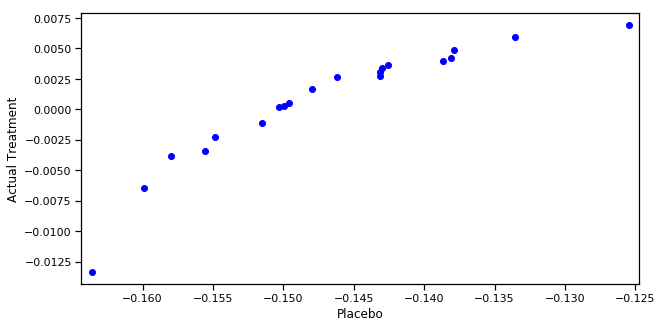

In [255]:
# QQ-Plot to compare empirical distributions. If straight line, no significant difference from placebo treatment.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Placebo', ylabel='Actual Treatment')
pylab.show()

In [256]:
alpha = .05
critical_value = np.sqrt(-np.log(alpha) / 2) * np.sqrt(2 * n_iter/(n_iter * n_iter))

ks_test = scipy.stats.ks_2samp(np.array(placebo_results), np.array(treatment_results))
if ks_test[0] > critical_value and ks_test[1] < alpha:
    print('Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))
else: 
    print('Cannot reject hypothesis that placebo and actual treatment are identical distribution (K-S statistic: {}, p-value: {})'.format(ks_test[0], ks_test[1]))

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.0, p-value: 5.546615975073734e-10)
